In [16]:
import numpy as np
import pandas as pd
import copy
from numpy import nan
import matplotlib.pyplot as plt


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


RANDOM_SEED = 6 

## First step : Importing and Visualizing the data

In [18]:
#Train dataset features
trainFeatures_df = pd.read_csv("data/Training_Features.csv", index_col="respondent_id")
trainFeatures_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [19]:
#Train dataset lables
trainLabels_df = pd.read_csv("data/Training_Labels.csv", index_col="respondent_id")
trainLabels_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [20]:
trainFeatures_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

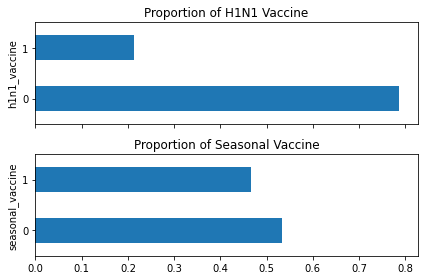

In [21]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = trainLabels_df.shape[0]

(trainLabels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(trainLabels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [22]:
#Checking either two classes have any correlations
pd.crosstab(
    trainLabels_df["h1n1_vaccine"], 
    trainLabels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


The result shows there is correclation among two classes. The majority of people who received the h1n1_vaccine, they took seasonal_vaccine, too. 

In [23]:
joined_df = trainFeatures_df.join(trainLabels_df)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [24]:
def vaccination_rate_plot(col, target, data, ax=None):
    
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

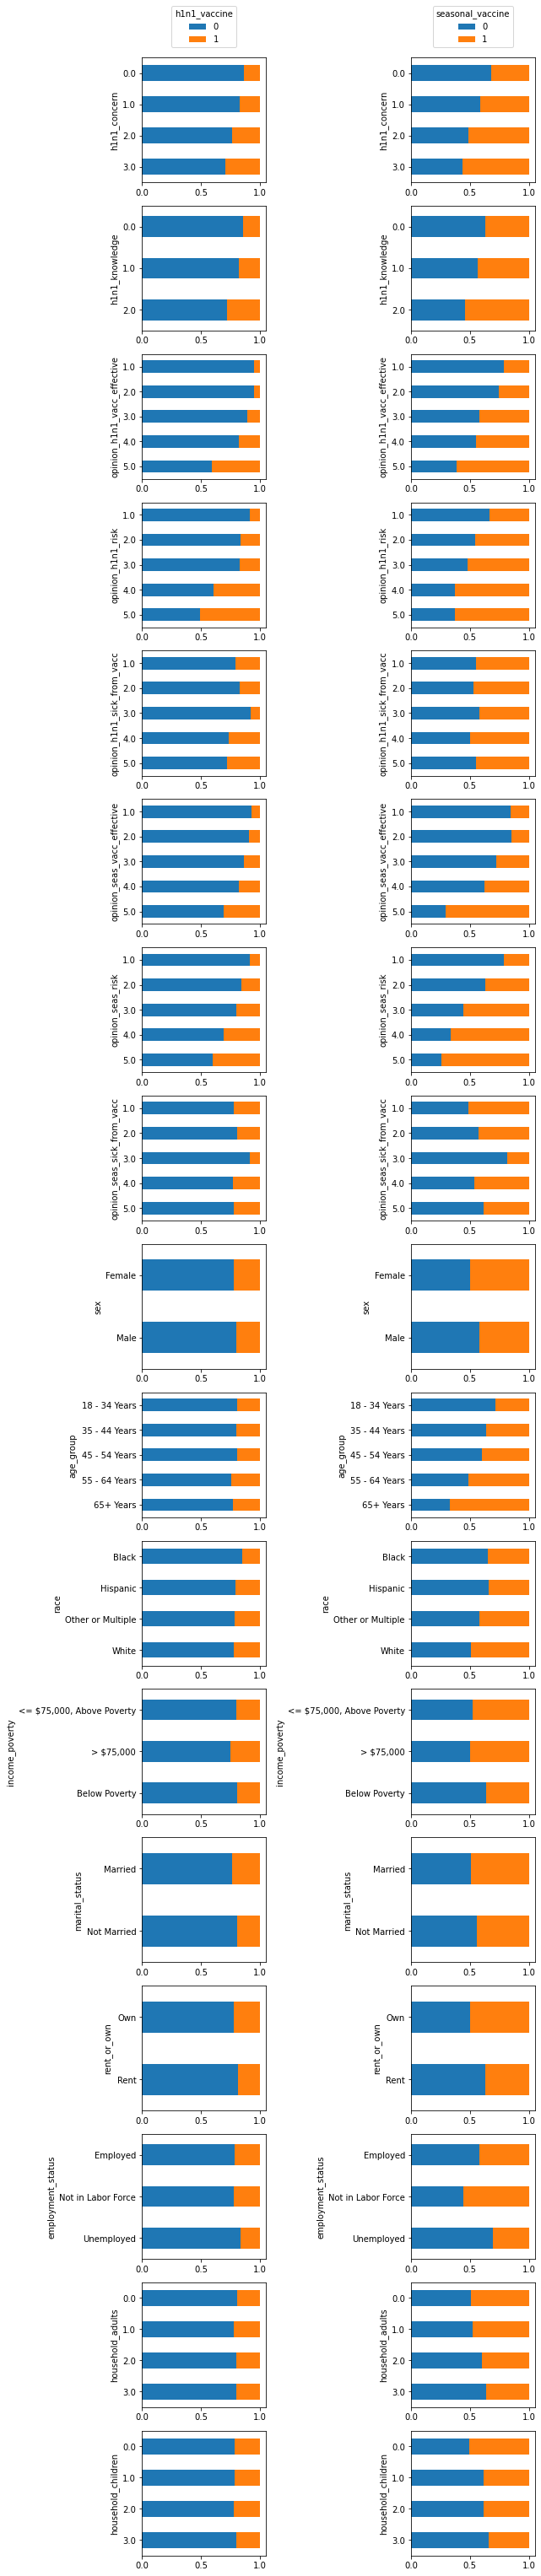

In [25]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
    'income_poverty',
    'marital_status',                
    'rent_or_own',                    
    'employment_status',              
    'household_adults',             
    'household_children',                
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

The results show, there is significant difference among people who took seasonal_vaccine in comparison with people who took h1n1_vaccine based on opininion_h1n1_sick_from_vacc, income_poverty, age_group, employment_status. Some of these features required numeric values instead of categorical classes such as age group. These numeric values for them are defined next.

In [26]:


seperate_cols = ["age_group", "income_poverty","employment_status"]

ageMean_map = {'18 - 34 Years': 26,'35 - 44 Years': 40,'45 - 54 Years': 50,'55 - 64 Years': 60,
                '65+ Years': 70 }

income_map = {'Below Poverty': 1,'<= $75,000, Above Poverty': 2,'> $75,000':3}

employmentStatus_map = {'Employed':1,'Not in Labor Force': 2,'Unemployed':3}


full_map = {"age_group":ageMean_map, "income_poverty":income_map,"employment_status":employmentStatus_map}


def map_to_numeric(x, mapping):
    if mapping.get(x) == None:
        return nan
    else:
        return mapping.get(x)
    
def convert(df):
    new_df = copy.deepcopy(df)
    for col in seperate_cols:
        new_df[col] = df[col].apply(lambda x: map_to_numeric(x, full_map.get(col))) 
    return new_df

numeric_to_cat_transofrmer = FunctionTransformer(convert)   



## Second step: Creating the preprocessor for final pipeline
This pipeline will be used for training the model, and finally the trained model will be used for predicting unseen data.

In [27]:
# creating the preprocessor stage of final pipeline
numeric_cols = trainFeatures_df.columns[trainFeatures_df.dtypes != "object"].values
non_numeric_cols = trainFeatures_df.columns[trainFeatures_df.dtypes == "object"].values


high_missing_cols = []
non_numeric_cols = [x for x in non_numeric_cols if (x not in high_missing_cols and x not in seperate_cols)]
numeric_cols = [x for x in numeric_cols if (x not in high_missing_cols and x not in seperate_cols)]

# chaining preprocessing into a Pipeline object
numeric_to_cat_preprocessing_steps = Pipeline([
    ('convert_to_cat', numeric_to_cat_transofrmer),
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler()),
    ])

numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))])

non_numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# creating the preprocessor stage of final pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols),
        ("numeric_to_cat", numeric_to_cat_preprocessing_steps, seperate_cols)
    ],
    remainder = "drop"
)



In [28]:
# MLPClassifier: Multi-layer Perceptron classifier
# XGBClassifier: Gradient Boosting for classification (Gradient Boosting is an iterative functional gradient algorithm, 
#                i.e an algorithm which minimizes a loss function by iteratively choosing a function that points towards the negative gradient)

est_mlp = MLPClassifier(hidden_layer_sizes=(200,100,), learning_rate='invscaling', learning_rate_init=0.001,
                          power_t=0.5, max_iter=500, shuffle=True, tol=0.0001, 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(learning_rate =0.05, n_estimators=350, max_depth=5, min_child_weight=2, gamma=0.2,
                             subsample=0.8,colsample_bytree=0.4,reg_alpha=0.1,objective= 'binary:logistic',nthread=4,
                              scale_pos_weight=1 ,reg_lambda = 10 , random_state = 42)


estimators_stacked = [('xbg', est_xgb),
              ('mlp', est_mlp)]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(penalty="l2"),
                                    stack_method='predict_proba'
                                  )

In [29]:
estimators = MultiOutputClassifier(
    estimator = stacked_estimator
)

In [30]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [31]:
# dividing the dataset to train and validation data

X_train, X_eval, y_train, y_eval = train_test_split(
    trainFeatures_df,
    trainLabels_df,
    test_size=0.2,
    shuffle=True,
    stratify=trainLabels_df,
    random_state=RANDOM_SEED
)

In [32]:
# Train model
full_pipeline.fit(X_train, y_train)

# Predicting on valuation data
preds = full_pipeline.predict_proba(X_eval)
preds

[array([[0.9360075 , 0.0639925 ],
        [0.94059007, 0.05940993],
        [0.91395565, 0.08604435],
        ...,
        [0.85500457, 0.14499543],
        [0.66734602, 0.33265398],
        [0.94071334, 0.05928666]]),
 array([[0.4454089 , 0.5545911 ],
        [0.92393187, 0.07606813],
        [0.46508579, 0.53491421],
        ...,
        [0.27426814, 0.72573186],
        [0.10378777, 0.89621223],
        [0.91372075, 0.08627925]])]

In [33]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8579,0.063992,0.554591
22908,0.059410,0.076068
20210,0.086044,0.534914
25013,0.094265,0.225503
20669,0.094912,0.832256


In [34]:
roc_auc_score(y_eval, y_preds)

0.8723711729118238

In [35]:
full_pipeline.fit(trainFeatures_df, trainLabels_df)
None

In [36]:
#Test dataset features
testFeatures_df = pd.read_csv("data/Test_Features.csv", index_col="respondent_id")
testFeatures_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [37]:
test_probas = full_pipeline.predict_proba(testFeatures_df)
test_probas

[array([[0.91483719, 0.08516281],
        [0.94191586, 0.05808414],
        [0.86657778, 0.13342222],
        ...,
        [0.87481966, 0.12518034],
        [0.94277226, 0.05722774],
        [0.43384734, 0.56615266]]),
 array([[0.78670722, 0.21329278],
        [0.92421495, 0.07578505],
        [0.2338796 , 0.7661204 ],
        ...,
        [0.84747572, 0.15252428],
        [0.74360768, 0.25639232],
        [0.40060508, 0.59939492]])]